In [1]:
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as optim
import os

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import coolwarm
plt.set_cmap('cividis')

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


<Figure size 432x288 with 0 Axes>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10 , 100)  
        self.fc2 = nn.Linear(100, 100)
        self.d = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(100, 6)
        

    def forward(self, x):
        #Applying relu non-linearity
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope =0.1)
        x = self.fc2(x)
        x = F.leaky_relu(x, negative_slope =0.1) 
        x = self.d(x)
        x = self.fc4(x)
        return x


model = Net()


In [3]:
def normalize(inp_data, out_data = np.zeros(1000)):
    
    #t_start
    inp_data[:,0] /= 600    # 10 mins
    #t_operating
    inp_data[:,1] = np.log10(inp_data[:,1]+1)/6 # 2 days
    #t_tracktime
    #inp_data[:,2] /= 2592000   # 1 month
    inp_data[:,2] = inp_data[:,2]/(2592000*2)
    #t_cumsum
    inp_data[:,3] = np.log10(inp_data[:,3]+1)/12 # 2 months
    # power 
    inp_data[:,4] /= 500
    #guidevane
    inp_data[:,5] /= 180
    # draft_pressure
    inp_data[:,6] /= 500
    # spiral_pressure
    inp_data[:,7] /= 10000
    # rotational speed
    inp_data[:,8] /= 500
    
    ## output
    out_data /= 2000
    
    return inp_data, out_data
    
    
    

In [4]:
f_dataset = np.load('Input_to_NN_notNAN.npz', allow_pickle = True)
print(f_dataset['X'].shape, f_dataset['Y'].shape )

inp_data = f_dataset['X']
out_data = f_dataset['Y'] 

inp_data, out_data = normalize(inp_data, out_data)

(1350000, 10) (1350000, 6)
[1.49223927e+02 1.16750037e+05 8.51013559e+05 9.64145371e+10
 2.98626508e+02 9.12187171e+01 1.55861493e+02 5.31218745e+03
 1.07874637e+02 9.97639259e-01]
[1608.72025976 1487.72319511 1688.32415064 1602.36688526 1636.97079258
 1678.00840345]
0 0
[0.24870655 0.79554728 0.16416157 0.89814276 0.59725302 0.50677065
 0.31172299 0.53121874 0.21574927 0.99763926]
[0.80436013 0.7438616  0.84416208 0.80118344 0.8184854  0.8390042 ]
Max : [0.40833333 0.93305641 0.35996914 0.93313257 0.64660466 0.53433622
 0.53671198 0.55127715 0.2167375  1.        ]
Max : [0.81010815 0.74734008 0.84716078 0.80274691 0.81949943 0.84172924]
[0.21592856 0.21592855 0.21592854 ... 0.21618452 0.21618452 0.21618451]
0.4083333333333333


In [5]:
class SeqDataset(data.Dataset):

    def __init__(self, dataset , labelset):
        super().__init__()
        self.data = torch.from_numpy(dataset)
        self.labels = torch.from_numpy(labelset)
        
               
    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        out_data = self.labels[idx]
        return inp_data, out_data

In [6]:
full_dataset = SeqDataset(np.array(inp_data , dtype= 'float32'), np.array(out_data, dtype = 'float32') )
print(len(full_dataset))

1350000


In [7]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset.data))
test_size = len(full_dataset.data)-train_size -val_size
batch = 256

print(train_size, val_size, test_size)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size,val_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=batch, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(val_dataset, batch_size=batch)
test_loader  = data.DataLoader(test_dataset, batch_size=batch)

944999 135000 270001


In [8]:
model = model.to(device)    
print(model)

## Initializing optimizer
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Net(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (d): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)


In [9]:
def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))  


def calculate_loss(data, labels, model, device=torch.device("cuda:0")):
    target = model.forward(data)
    loss = MAPELoss(target, labels)
    l1_lambda = 0.01
    l1_reg = torch.tensor(0.).to(device)
    for name, params in model.named_parameters() :
        if 'fc2' in name:
            l1_reg += torch.abs(params).sum()
    loss += l1_lambda * l1_reg
    return loss, target                  # target = predicted_bolt_tensile


def training(model, train_loader, val_loader, epochs, optimizer, checkpoint_path, filename,
             device=torch.device("cuda:0"), aux_loss=False):
    min_val_loss = np.inf
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        model.train()
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data, labels = data.to(device), labels.to(device)
            # Calculate Train Loss
            loss, _ = calculate_loss(data, labels, model)
            # back-propagate Train loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        for data, labels in val_loader:
            if torch.cuda.is_available():
                data, labels = data.to(device), labels.to(device)
            # Calculate Validation Loss
            loss, _ = calculate_loss(data, labels, model)
            val_loss += loss.item()

        print(
            f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t'
            f' Validation Loss: {val_loss / len(val_loader)}')

        if min_val_loss > val_loss:
            print('trigger times: 0')
            trigger_times = 0
            print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
            min_val_loss = val_loss
            # Saving State Dict
            os.makedirs(checkpoint_path, exist_ok=True)
            pretrained_filename = os.path.join(checkpoint_path, filename)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss}, pretrained_filename)

    return model

In [10]:
available_filename = ['simple_nn_model.pth']
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "models/trained_models/"

# Check whether pretrained model exists. If yes, load it and skip training
pretrained_filename = os.path.join(CHECKPOINT_PATH, available_filename[0]  )
print(pretrained_filename)
if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
    checkpoint = torch.load(pretrained_filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    print(epoch)
else:
    model = training(model, train_loader, val_loader, 100, optimizer, CHECKPOINT_PATH, available_filename[0],device)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

models/trained_models/simple_nn_model_2.pth


  1%|▊                                                                                 | 1/100 [00:23<39:20, 23.84s/it]

Epoch 1 		 Training Loss: 0.10746741042613975 		 Validation Loss: 0.013113431420854547
trigger times: 0
Validation Loss Decreased(inf--->6.923892) 	 Saving The Model


  2%|█▋                                                                                | 2/100 [00:47<38:38, 23.66s/it]

Epoch 2 		 Training Loss: 0.013158716433470859 		 Validation Loss: 0.012493557113251
trigger times: 0
Validation Loss Decreased(6.923892--->6.596598) 	 Saving The Model


  3%|██▍                                                                               | 3/100 [01:09<37:15, 23.05s/it]

Epoch 3 		 Training Loss: 0.012495769440887566 		 Validation Loss: 0.012359978759901203
trigger times: 0
Validation Loss Decreased(6.596598--->6.526069) 	 Saving The Model


  4%|███▎                                                                              | 4/100 [01:32<36:28, 22.79s/it]

Epoch 4 		 Training Loss: 0.012291450953992667 		 Validation Loss: 0.011852820010531243
trigger times: 0
Validation Loss Decreased(6.526069--->6.258289) 	 Saving The Model


  5%|████                                                                              | 5/100 [01:54<35:59, 22.73s/it]

Epoch 5 		 Training Loss: 0.012330798376467663 		 Validation Loss: 0.012347851262540755


  6%|████▉                                                                             | 6/100 [02:17<35:24, 22.60s/it]

Epoch 6 		 Training Loss: 0.012340277836859162 		 Validation Loss: 0.012016644415614957


  7%|█████▋                                                                            | 7/100 [02:39<34:52, 22.50s/it]

Epoch 7 		 Training Loss: 0.01233672866392381 		 Validation Loss: 0.012305710187788602


  8%|██████▌                                                                           | 8/100 [03:01<34:25, 22.45s/it]

Epoch 8 		 Training Loss: 0.012291125362005717 		 Validation Loss: 0.01204604836653523


  9%|███████▍                                                                          | 9/100 [03:24<33:58, 22.40s/it]

Epoch 9 		 Training Loss: 0.012277422695130763 		 Validation Loss: 0.012196221681678611


 10%|████████                                                                         | 10/100 [03:46<33:52, 22.59s/it]

Epoch 10 		 Training Loss: 0.012268791599206746 		 Validation Loss: 0.012026529058912825


 11%|████████▉                                                                        | 11/100 [04:09<33:23, 22.52s/it]

Epoch 11 		 Training Loss: 0.012236050266517157 		 Validation Loss: 0.01237172848072298


 12%|█████████▋                                                                       | 12/100 [04:31<33:03, 22.54s/it]

Epoch 12 		 Training Loss: 0.01222829218571327 		 Validation Loss: 0.012100651369881674


 13%|██████████▌                                                                      | 13/100 [04:54<32:44, 22.58s/it]

Epoch 13 		 Training Loss: 0.012215006593650142 		 Validation Loss: 0.012511025884922481


 14%|███████████▎                                                                     | 14/100 [05:16<32:16, 22.52s/it]

Epoch 14 		 Training Loss: 0.012197624323513652 		 Validation Loss: 0.011990006090579272


 15%|████████████▏                                                                    | 15/100 [05:40<32:13, 22.74s/it]

Epoch 15 		 Training Loss: 0.012156273486646283 		 Validation Loss: 0.012036717902502101


 16%|████████████▉                                                                    | 16/100 [06:03<32:01, 22.88s/it]

Epoch 16 		 Training Loss: 0.012165979641449061 		 Validation Loss: 0.012015867027609298


 17%|█████████████▊                                                                   | 17/100 [06:27<32:16, 23.33s/it]

Epoch 17 		 Training Loss: 0.0121765511844179 		 Validation Loss: 0.011926323030793079


 18%|██████████████▌                                                                  | 18/100 [06:51<32:10, 23.54s/it]

Epoch 18 		 Training Loss: 0.012145656315936318 		 Validation Loss: 0.012120283656810043


 19%|███████████████▍                                                                 | 19/100 [07:15<31:42, 23.48s/it]

Epoch 19 		 Training Loss: 0.01214223385156937 		 Validation Loss: 0.01209833182281617


 20%|████████████████▏                                                                | 20/100 [07:40<32:08, 24.11s/it]

Epoch 20 		 Training Loss: 0.012124227029600705 		 Validation Loss: 0.011869323917904474


 21%|█████████████████                                                                | 21/100 [08:06<32:25, 24.63s/it]

Epoch 21 		 Training Loss: 0.012090740186941718 		 Validation Loss: 0.011713816734933944
trigger times: 0
Validation Loss Decreased(6.258289--->6.184895) 	 Saving The Model


 22%|█████████████████▊                                                               | 22/100 [08:32<32:27, 24.96s/it]

Epoch 22 		 Training Loss: 0.012099020788408221 		 Validation Loss: 0.011792496160716948


 23%|██████████████████▋                                                              | 23/100 [08:57<32:12, 25.10s/it]

Epoch 23 		 Training Loss: 0.012072597795340935 		 Validation Loss: 0.012068480604229439


 24%|███████████████████▍                                                             | 24/100 [09:21<31:19, 24.73s/it]

Epoch 24 		 Training Loss: 0.012088101861362081 		 Validation Loss: 0.011807442085365907


 25%|████████████████████▎                                                            | 25/100 [09:44<30:22, 24.29s/it]

Epoch 25 		 Training Loss: 0.012065487398797018 		 Validation Loss: 0.01176933056470289


 26%|█████████████████████                                                            | 26/100 [10:07<29:25, 23.85s/it]

Epoch 26 		 Training Loss: 0.012059058887826995 		 Validation Loss: 0.012074740988089505


 27%|█████████████████████▊                                                           | 27/100 [10:31<29:00, 23.85s/it]

Epoch 27 		 Training Loss: 0.01205860393712778 		 Validation Loss: 0.011780534544606891


 28%|██████████████████████▋                                                          | 28/100 [10:55<28:29, 23.75s/it]

Epoch 28 		 Training Loss: 0.012011710907360607 		 Validation Loss: 0.011871453406373885


 29%|███████████████████████▍                                                         | 29/100 [11:18<27:49, 23.52s/it]

Epoch 29 		 Training Loss: 0.012026745889338898 		 Validation Loss: 0.011934760853888072


 30%|████████████████████████▎                                                        | 30/100 [11:40<27:13, 23.34s/it]

Epoch 30 		 Training Loss: 0.012015473611543847 		 Validation Loss: 0.011844981396500247


 31%|█████████████████████████                                                        | 31/100 [12:04<27:00, 23.48s/it]

Epoch 31 		 Training Loss: 0.012007933457194548 		 Validation Loss: 0.012034463098230348


 32%|█████████████████████████▉                                                       | 32/100 [12:28<26:38, 23.51s/it]

Epoch 32 		 Training Loss: 0.011978400706138691 		 Validation Loss: 0.01192298375782698


 33%|██████████████████████████▋                                                      | 33/100 [12:50<25:53, 23.19s/it]

Epoch 33 		 Training Loss: 0.01199379615537142 		 Validation Loss: 0.012225870686851329


 34%|███████████████████████████▌                                                     | 34/100 [13:13<25:14, 22.94s/it]

Epoch 34 		 Training Loss: 0.01195838355260695 		 Validation Loss: 0.011953128060805753


 35%|████████████████████████████▎                                                    | 35/100 [13:36<25:04, 23.15s/it]

Epoch 35 		 Training Loss: 0.011965524452425332 		 Validation Loss: 0.011786894959214173


 36%|█████████████████████████████▏                                                   | 36/100 [13:59<24:33, 23.02s/it]

Epoch 36 		 Training Loss: 0.011964093837750794 		 Validation Loss: 0.011829422654541717


 37%|█████████████████████████████▉                                                   | 37/100 [14:22<24:01, 22.88s/it]

Epoch 37 		 Training Loss: 0.011969817251237516 		 Validation Loss: 0.011740666325556847


 38%|██████████████████████████████▊                                                  | 38/100 [14:46<24:08, 23.35s/it]

Epoch 38 		 Training Loss: 0.01193097802255009 		 Validation Loss: 0.012064520003288195


 39%|███████████████████████████████▌                                                 | 39/100 [15:10<23:49, 23.44s/it]

Epoch 39 		 Training Loss: 0.01195782786691917 		 Validation Loss: 0.011826841635135652


 40%|████████████████████████████████▍                                                | 40/100 [15:34<23:38, 23.64s/it]

Epoch 40 		 Training Loss: 0.011943635367012482 		 Validation Loss: 0.011969486754175952


 41%|█████████████████████████████████▏                                               | 41/100 [15:58<23:20, 23.73s/it]

Epoch 41 		 Training Loss: 0.011942600257607922 		 Validation Loss: 0.011857539090807692


 42%|██████████████████████████████████                                               | 42/100 [16:22<23:01, 23.82s/it]

Epoch 42 		 Training Loss: 0.011952584068409733 		 Validation Loss: 0.011723926932917851


 43%|██████████████████████████████████▊                                              | 43/100 [16:46<22:37, 23.82s/it]

Epoch 43 		 Training Loss: 0.011926933132925515 		 Validation Loss: 0.012094346603562095


 44%|███████████████████████████████████▋                                             | 44/100 [17:09<22:08, 23.72s/it]

Epoch 44 		 Training Loss: 0.011920119732904971 		 Validation Loss: 0.011743247027466581


 45%|████████████████████████████████████▍                                            | 45/100 [17:32<21:28, 23.42s/it]

Epoch 45 		 Training Loss: 0.011925946473994574 		 Validation Loss: 0.011705310512545773
trigger times: 0
Validation Loss Decreased(6.184895--->6.180404) 	 Saving The Model


 46%|█████████████████████████████████████▎                                           | 46/100 [17:56<21:14, 23.60s/it]

Epoch 46 		 Training Loss: 0.011923713404690305 		 Validation Loss: 0.011599777500977683
trigger times: 0
Validation Loss Decreased(6.180404--->6.124683) 	 Saving The Model


 47%|██████████████████████████████████████                                           | 47/100 [18:21<21:11, 23.99s/it]

Epoch 47 		 Training Loss: 0.011881924370584837 		 Validation Loss: 0.01203429902670905


 48%|██████████████████████████████████████▉                                          | 48/100 [18:45<20:50, 24.04s/it]

Epoch 48 		 Training Loss: 0.011906745914239623 		 Validation Loss: 0.011669880195492597


 49%|███████████████████████████████████████▋                                         | 49/100 [19:09<20:26, 24.05s/it]

Epoch 49 		 Training Loss: 0.011879937245127745 		 Validation Loss: 0.011894949147421303


 50%|████████████████████████████████████████▌                                        | 50/100 [19:33<20:03, 24.08s/it]

Epoch 50 		 Training Loss: 0.01188468812949465 		 Validation Loss: 0.011892299035521732


 51%|█████████████████████████████████████████▎                                       | 51/100 [19:57<19:39, 24.07s/it]

Epoch 51 		 Training Loss: 0.011875962540537596 		 Validation Loss: 0.011939318159200026


 52%|██████████████████████████████████████████                                       | 52/100 [20:23<19:38, 24.55s/it]

Epoch 52 		 Training Loss: 0.011863322946967406 		 Validation Loss: 0.011835054734326673


 53%|██████████████████████████████████████████▉                                      | 53/100 [20:46<18:59, 24.23s/it]

Epoch 53 		 Training Loss: 0.011862736516027827 		 Validation Loss: 0.011903877558793421


 54%|███████████████████████████████████████████▋                                     | 54/100 [21:14<19:28, 25.41s/it]

Epoch 54 		 Training Loss: 0.011864304968966633 		 Validation Loss: 0.011817338498958357


 55%|████████████████████████████████████████████▌                                    | 55/100 [21:39<18:55, 25.24s/it]

Epoch 55 		 Training Loss: 0.011862638178860567 		 Validation Loss: 0.011958068102654634


 56%|█████████████████████████████████████████████▎                                   | 56/100 [22:03<18:05, 24.68s/it]

Epoch 56 		 Training Loss: 0.011848282200932519 		 Validation Loss: 0.011806922395022191


 57%|██████████████████████████████████████████████▏                                  | 57/100 [22:27<17:38, 24.61s/it]

Epoch 57 		 Training Loss: 0.011852415130692942 		 Validation Loss: 0.011502498736125275
trigger times: 0
Validation Loss Decreased(6.124683--->6.073319) 	 Saving The Model


 58%|██████████████████████████████████████████████▉                                  | 58/100 [22:51<17:10, 24.53s/it]

Epoch 58 		 Training Loss: 0.011835121346546266 		 Validation Loss: 0.011793185932081982


 59%|███████████████████████████████████████████████▊                                 | 59/100 [23:15<16:34, 24.26s/it]

Epoch 59 		 Training Loss: 0.011834947674441099 		 Validation Loss: 0.011643984487322583


 60%|████████████████████████████████████████████████▌                                | 60/100 [23:39<16:06, 24.16s/it]

Epoch 60 		 Training Loss: 0.011815873032475641 		 Validation Loss: 0.012034559860529209


 61%|█████████████████████████████████████████████████▍                               | 61/100 [24:03<15:36, 24.01s/it]

Epoch 61 		 Training Loss: 0.011834312343641417 		 Validation Loss: 0.011738923447079618


 62%|██████████████████████████████████████████████████▏                              | 62/100 [24:27<15:16, 24.12s/it]

Epoch 62 		 Training Loss: 0.011834603851139788 		 Validation Loss: 0.011684324481228197


 63%|███████████████████████████████████████████████████                              | 63/100 [24:50<14:40, 23.79s/it]

Epoch 63 		 Training Loss: 0.011830623557100255 		 Validation Loss: 0.011414999145816899
trigger times: 0
Validation Loss Decreased(6.073319--->6.027120) 	 Saving The Model


 64%|███████████████████████████████████████████████████▊                             | 64/100 [25:13<14:02, 23.39s/it]

Epoch 64 		 Training Loss: 0.011813516894103598 		 Validation Loss: 0.01160130463540554


 65%|████████████████████████████████████████████████████▋                            | 65/100 [25:35<13:30, 23.15s/it]

Epoch 65 		 Training Loss: 0.011805688239688538 		 Validation Loss: 0.011722475639544427


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [25:58<13:07, 23.15s/it]

Epoch 66 		 Training Loss: 0.011808368351650623 		 Validation Loss: 0.011837695649415819


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [26:22<12:53, 23.44s/it]

Epoch 67 		 Training Loss: 0.011798331925286667 		 Validation Loss: 0.011801455674382547


 68%|███████████████████████████████████████████████████████                          | 68/100 [26:47<12:38, 23.70s/it]

Epoch 68 		 Training Loss: 0.011792435669583684 		 Validation Loss: 0.011842589412646537


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [27:10<12:06, 23.43s/it]

Epoch 69 		 Training Loss: 0.011804853348236555 		 Validation Loss: 0.01194554926813439


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [27:32<11:36, 23.22s/it]

Epoch 70 		 Training Loss: 0.011809127477197765 		 Validation Loss: 0.011661306466328713


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [27:55<11:09, 23.09s/it]

Epoch 71 		 Training Loss: 0.011800984830316231 		 Validation Loss: 0.012037665126351358


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [28:18<10:43, 22.99s/it]

Epoch 72 		 Training Loss: 0.01179643358633556 		 Validation Loss: 0.011677079624143627


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [28:41<10:22, 23.05s/it]

Epoch 73 		 Training Loss: 0.011788539067405296 		 Validation Loss: 0.011551329035269604


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [29:04<09:55, 22.91s/it]

Epoch 74 		 Training Loss: 0.011784153660157289 		 Validation Loss: 0.011650050275916741


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [29:26<09:31, 22.85s/it]

Epoch 75 		 Training Loss: 0.011782930414256721 		 Validation Loss: 0.011742203394092168


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [29:50<09:14, 23.10s/it]

Epoch 76 		 Training Loss: 0.011764872190397433 		 Validation Loss: 0.011863696794590038


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [30:13<08:47, 22.95s/it]

Epoch 77 		 Training Loss: 0.01176458026000645 		 Validation Loss: 0.011728530793775324


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [30:35<08:22, 22.85s/it]

Epoch 78 		 Training Loss: 0.011750652440158745 		 Validation Loss: 0.011561073062969654


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [30:58<07:59, 22.84s/it]

Epoch 79 		 Training Loss: 0.011734426812607158 		 Validation Loss: 0.01164314784920972


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [31:21<07:35, 22.76s/it]

Epoch 80 		 Training Loss: 0.01174619429739986 		 Validation Loss: 0.011677406391368784


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [31:43<07:12, 22.74s/it]

Epoch 81 		 Training Loss: 0.011753313288807191 		 Validation Loss: 0.011583808613729409


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [32:06<06:48, 22.71s/it]

Epoch 82 		 Training Loss: 0.011749955178047947 		 Validation Loss: 0.011524699203260807


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [32:29<06:25, 22.69s/it]

Epoch 83 		 Training Loss: 0.011741210479189374 		 Validation Loss: 0.011519035671936404


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [32:52<06:08, 23.04s/it]

Epoch 84 		 Training Loss: 0.0117339070102155 		 Validation Loss: 0.011678534551086186


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [33:17<05:50, 23.40s/it]

Epoch 85 		 Training Loss: 0.011721365611250324 		 Validation Loss: 0.011670154110161644


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [33:41<05:29, 23.56s/it]

Epoch 86 		 Training Loss: 0.011745635130922345 		 Validation Loss: 0.011558954700982818


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [34:05<05:08, 23.70s/it]

Epoch 87 		 Training Loss: 0.011743741572979131 		 Validation Loss: 0.011481305046331589


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [34:29<04:48, 24.04s/it]

Epoch 88 		 Training Loss: 0.011730873211663174 		 Validation Loss: 0.011794414258364475


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [34:54<04:26, 24.18s/it]

Epoch 89 		 Training Loss: 0.011730230611702818 		 Validation Loss: 0.01155869071336576


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [35:18<04:02, 24.27s/it]

Epoch 90 		 Training Loss: 0.011723452037999184 		 Validation Loss: 0.011732014582252525


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [35:43<03:39, 24.41s/it]

Epoch 91 		 Training Loss: 0.011738725471106189 		 Validation Loss: 0.011614816427357833


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [36:08<03:15, 24.50s/it]

Epoch 92 		 Training Loss: 0.011725985804641837 		 Validation Loss: 0.01172092296253664


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [36:31<02:48, 24.02s/it]

Epoch 93 		 Training Loss: 0.011727623880692725 		 Validation Loss: 0.011454975759878642


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [36:53<02:21, 23.55s/it]

Epoch 94 		 Training Loss: 0.011681246079213814 		 Validation Loss: 0.011484273035559014


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [37:16<01:56, 23.39s/it]

Epoch 95 		 Training Loss: 0.011728797056965794 		 Validation Loss: 0.011599121124935195


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [37:39<01:33, 23.29s/it]

Epoch 96 		 Training Loss: 0.011734522738327698 		 Validation Loss: 0.011691271609654932


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [38:03<01:10, 23.45s/it]

Epoch 97 		 Training Loss: 0.011710376550895884 		 Validation Loss: 0.011709689730637227


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [38:26<00:46, 23.23s/it]

Epoch 98 		 Training Loss: 0.011709729592567922 		 Validation Loss: 0.01168203478410953


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [38:48<00:23, 23.03s/it]

Epoch 99 		 Training Loss: 0.011726369423500586 		 Validation Loss: 0.01171353172729582


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [39:12<00:00, 23.53s/it]

Epoch 100 		 Training Loss: 0.011711082110634118 		 Validation Loss: 0.01178574704416943


In [11]:
checkpoint = torch.load(pretrained_filename)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
test_loss = 0.0

with torch.no_grad():
    for i, (data, labels) in tqdm(enumerate(test_loader)):
        if torch.cuda.is_available():
            data, labels = data.to(device), labels.to(device)
        loss, target = calculate_loss(data, labels, model)  
        test_loss += loss.item()

print("Loss:", test_loss / len(test_loader))

1055it [00:04, 261.15it/s]

Loss: 0.011416346066017852


## Prediction Data

In [30]:
prediction_input = np.load('prediction_input.npz')
print(prediction_input['X'].shape)

pred_inp,_ = normalize(prediction_input['X'])
pred_inp = torch.tensor(pred_inp.astype('float32')).to(device)

pred_target = model.forward(pred_inp)
print(pred_target.shape)




(226364, 10)
torch.Size([226364, 6])


In [31]:
pred_target = pred_target.detach().cpu().numpy()*2000  # denormalizing based on our training regime

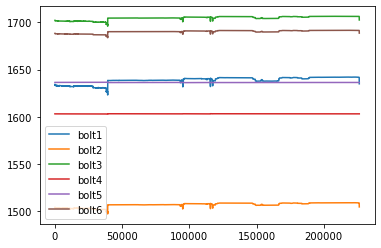

In [38]:
plt.plot(pred_target[:,0], label= 'bolt1')
plt.plot(pred_target[:,1], label= 'bolt2')
plt.plot(pred_target[:,2], label= 'bolt3')
plt.plot(pred_target[:,3], label= 'bolt4')
plt.plot(pred_target[:,4], label= 'bolt5')
plt.plot(pred_target[:,5], label= 'bolt6')
plt.legend()


In [35]:
# save file 

predict_data = pd.read_parquet('data/prediction_input.parquet', engine= 'fastparquet')

df = pd.DataFrame(pred_target ,
                  index=predict_data.index[:] , columns=['Bolt_1_Tensile' ,'Bolt_2_Tensile','Bolt_3_Tensile' ,
                   'Bolt_4_Tensile' ,'Bolt_5_Tensile' , 'Bolt_6_Tensile'])

os.makedirs('output', exist_ok=True)  
df.to_csv('output/out.csv', index=True, index_label= 'timepoints')

In [36]:
print(df.head())

                     Bolt_1_Tensile  Bolt_2_Tensile  Bolt_3_Tensile  \
timepoints                                                            
1971-01-25 11:06:49     1634.250610     1504.057861     1702.240601   
1971-01-25 11:06:50     1634.165039     1504.005127     1702.192383   
1971-01-25 11:06:51     1634.104248     1503.967407     1702.158203   
1971-01-25 11:06:52     1634.056763     1503.938110     1702.131470   
1971-01-25 11:06:53     1634.019043     1503.914673     1702.110352   

                     Bolt_4_Tensile  Bolt_5_Tensile  Bolt_6_Tensile  
timepoints                                                           
1971-01-25 11:06:49     1603.174194     1636.454102     1688.454590  
1971-01-25 11:06:50     1603.171631     1636.456787     1688.417725  
1971-01-25 11:06:51     1603.169678     1636.458496     1688.391235  
1971-01-25 11:06:52     1603.168213     1636.459961     1688.370728  
1971-01-25 11:06:53     1603.167114     1636.461182     1688.354370  
